In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"
from jax.config import config
# This slows down the computation by ~ x8. But single precision leads to discretization effects.
config.update("jax_enable_x64", True)  
import jax.numpy as jnp
from jax import jit, vmap, random

import sys
sys.path.append("..")
from hyperion.propagate import (   
    initialize_direction_led,
    make_photon_trajectory_fun,
    make_step_function,
    make_photon_sphere_intersection_func,
    make_cherenkov_spectral_sampling_func,
    make_loop_until_isec_or_maxtime,
    make_loop_for_n_steps,
    make_fixed_pos_time_initializer,
    make_monochromatic_initializer,
    collect_hits
)
from hyperion.medium import (
     cascadia_ref_index_func,
     mixed_hg_rayleigh_antares,
     sca_len_func_antares
)
from hyperion.constants import Constants
from hyperion.utils import calculate_min_number_steps, make_cascadia_abs_len_func
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import scipy.stats

# Propagate Photons from LED Lightsource

### Set detector parameters

In [2]:
# Define emitter position & emission time
emitter_x = jnp.array([0, 0, 0.0])
emitter_t = 0.0

det_dist = 50.0
# Define detector position & sensor radius (sensor is modelled as a sphere)
det_pos = jnp.array([0, 0, det_dist])
det_radius = 0.21

### Create Photon Initializers
Now setup the photon state initializers. We will use a function that injects photons at a fixed position and time and samples the direction and wavelength.
This function returns a dict which represents the initial photon state.

In [3]:
# LED emission profile (Lambert)

led_wavelength = 450

emission_dir_init = initialize_direction_led

# Monochromatic wavelength
wavelength_init = make_monochromatic_initializer(led_wavelength)

photon_init = make_fixed_pos_time_initializer(emitter_x, emitter_t, emission_dir_init, wavelength_init)

### Visualize Emission Profile 
`initialize_direction_led` samples theta from a cosine distribution (lamberts law) and phi uniformlym

Text(0.5, 0, 'Theta angle (rad)')

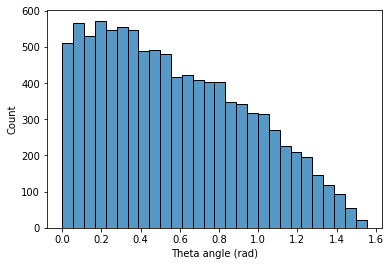

In [4]:
key = random.PRNGKey(0)

emission_dirs = vmap(emission_dir_init)(random.split(key, 10000))

sns.histplot(jnp.arccos(emission_dirs[:, 2]))
plt.xlabel("Theta angle (rad)")


### Create step function
Next, we are going to create a step function. This function will recieve a photon state, propagate the photon for one scattering step and return a new photon state.

In [10]:
# We want to calculate intersections with a sphere
intersection_f = make_photon_sphere_intersection_func(det_pos, det_radius)

# Use an approximation to the ANTARES scattering function
scattering_function = mixed_hg_rayleigh_antares

# Use the ANTARES wavelength dependent scattering length
scattering_length_function = sca_len_func_antares
"""
Note: you can also set the `scattering_length_function` to a lambda function:

scattering_length_function = lambda wavelength: my_scattering_length_in_m
"""
# Use the ANTARES wavelength dependent refractive index with cascadia basin properties
ref_index_func = cascadia_ref_index_func

# Create a step function, which will propagate the photon until the next scattering site.
# If the intersection function returns True, only propagate to intersection position.
step_fun = make_step_function(
    intersection_f=intersection_f,
    scattering_function=scattering_function,
    scattering_length_function=scattering_length_function,
    ref_index_func=ref_index_func,
)


### Visualize Photon Trajectories
It's easy to vectorize the propagation loop over multiple photons

Text(0, 0.5, 'z[m]')

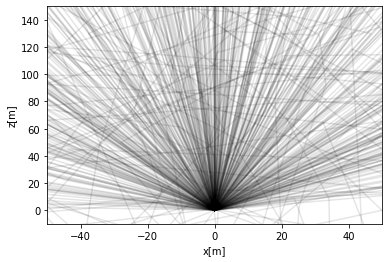

In [6]:
key, subkey = random.split(random.PRNGKey(32), 2)
n_photons = 500


# vmap and jit
step_fun_j = jit(vmap(step_fun, in_axes=0))
state = vmap(photon_init, in_axes=0)(random.split(subkey, n_photons))
positions = [np.asarray(state["pos"])]


key = random.split(key, n_photons)

for i in range(10):
    state, key = step_fun_j(state, key)
    positions.append(np.asarray(state["pos"]))

    
positions = np.asarray(positions)

for i_photon in range(n_photons):
    plt.plot(positions[:, i_photon, 0], positions[:, i_photon, 2], color="k", alpha=0.1);
plt.xlim(-50, 50)
plt.ylim(-10, 150)
plt.xlabel("x[m]")
plt.ylabel("z[m]")


### Step Size

Pick the step size such that 95% of all photons have a survival probability of < 1E-10

In [11]:
sca_len = scattering_length_function(led_wavelength)
abs_len = make_cascadia_abs_len_func(sca_len_func_antares)(led_wavelength)
print(f"Abs. length: {abs_len:.2f}m, Sca. length: {sca_len:.2f}m")

photon_prob_cutoff = 1E-10
steps = 7
prop_lengths = scipy.stats.gamma.rvs(steps, scale=sca_len, size=100000)
abs_weights = np.exp(-prop_lengths / abs_len)

perc_of_score = scipy.stats.percentileofscore(abs_weights, photon_prob_cutoff)
print(f"Percent of photons with surv prob < {photon_prob_cutoff:.0E}: {perc_of_score:.1f}")



Abs. length: 29.64m, Sca. length: 248.20m
Percent of photons with surv prob < 1E-10: 97.8


### Setup looping function

In [12]:
# Propagation is run until either photon intersects or max_time is reached
loop_func = make_loop_for_n_steps(steps)

# make a trajectory function
trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))

### Propagate Photons

In [13]:
key = random.PRNGKey(0)
n_photons = int(1E7)
initial_state, final_state = trajec_fun_v(random.split(key, num=n_photons))


### Plot arrival theta angle (spherical coordinates relative to [0, 0, 0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arccos
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


Text(0.5, 0, 'Indident angle (deg)')

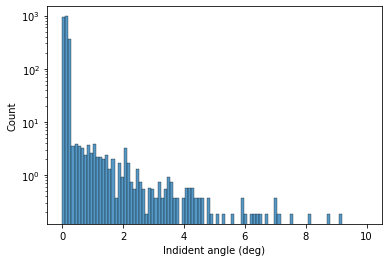

In [14]:
arriv_dirs = final_state["dir"][final_state["isec"]]
theta = np.arccos(arriv_dirs[:, 2])
phi = np.arccos(arriv_dirs[:, 0] / np.sin(theta))

c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

prop_dist = final_state["time"][final_state["isec"]] * c_medium_f(led_wavelength)/1E9 
abs_weight = np.exp(-prop_dist / abs_len)


sns.histplot(x=np.degrees(theta), bins=np.linspace(0, 10, 100), weights=abs_weight)
plt.semilogy()
plt.xlabel("Indident angle (deg)")



### Plot photon arrival position

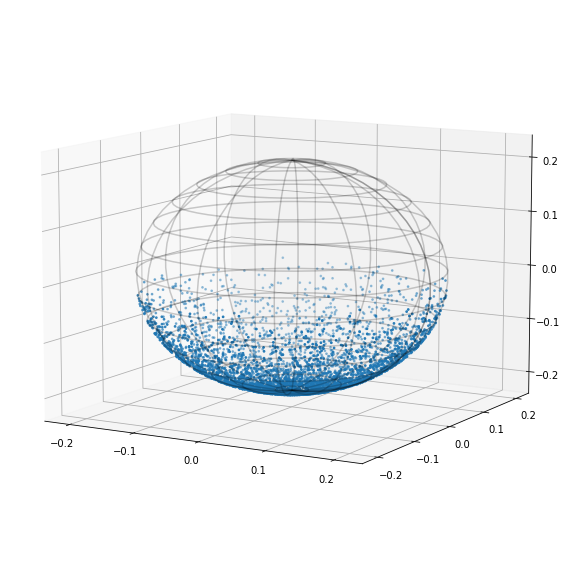

In [15]:
arriv_pos = final_state["pos"][final_state["isec"]]

det_center = np.asarray([0, 0, det_dist])
rel = (arriv_pos - det_center)
rel = rel / np.linalg.norm(rel, axis=1)[:, np.newaxis] * det_radius


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:30j]
x = det_radius*np.cos(u)*np.sin(v)
y = det_radius*np.sin(u)*np.sin(v)
z = det_radius*np.cos(v)
#ax.plot_surface(x, y, z, color="k", alpha=0.1)
ax.plot_wireframe(x, y, z, color="k", alpha=0.2, rcount=15, ccount=15)
ax.scatter(rel[:5000, 0], rel[:5000, 1], rel[:5000, 2], s=3)
ax.view_init(elev=10.)
#ax.plot(0, 0, -det_dist, "ok")
#ax.set_xlim(-10, 10)
#ax.set_ylim(-10, 10)
plt.tight_layout()




## Propagate multiple batches of photons
We can use another convenience function to propagate multiple batches of photons, and record only those that have hit our detector.

In [27]:
def collect_hits(traj_func, nphotons, nsims, seed=0, sim_limit=1e7):
    """Run photon prop multiple times and collect hits."""
    key = random.PRNGKey(seed)
    isec_times = []
    ar_dirs = []
    nphotons = int(nphotons)
    isec_pos = []

    total_detected_photons = 0
    sims_cnt = 0

    for i in range(nsims):
        key, subkey = random.split(key)
        initial_state, final_state = traj_func(random.split(key, num=nphotons))
        isecs = final_state["isec"]
        isec_times.append(np.asarray(final_state["time"][isecs]))      
        ar_dirs.append(np.asarray((final_state["dir"][isecs])))
        isec_pos.append(np.asarray(final_state["pos"][isecs]))

        sims_cnt = i
        total_detected_photons += jnp.sum(isecs)
        if sim_limit is not None and total_detected_photons > sim_limit:
            break

    isec_times = np.concatenate(isec_times)
    ar_dirs = np.vstack(ar_dirs)
    isec_pos = np.vstack(isec_pos)


    return isec_times, ar_dirs, isec_pos, sims_cnt


In [32]:
data = collect_hits(trajec_fun_v, 5E6, 10)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


Text(0.5, 0, 'Indident angle (deg)')

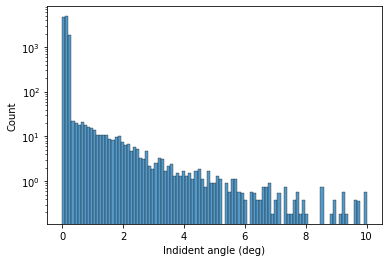

In [34]:
arriv_dirs = data[1]
#em_dirs = data[2]
theta = np.arccos(arriv_dirs[:, 2])
phi = np.arccos(arriv_dirs[:, 0] / np.sin(theta))

prop_dist = data[0] * c_medium_f(led_wavelength)/1E9 
abs_weight = np.exp(-prop_dist / abs_len)


sns.histplot(x=np.degrees(theta), bins=np.linspace(0, 10, 100), weights=abs_weight)
plt.semilogy()
plt.xlabel("Indident angle (deg)")


In [37]:
second_scattering_length_function = lambda wl: 100

second_step_fun = make_step_function(
    intersection_f=intersection_f,
    scattering_function=scattering_function,
    scattering_length_function=second_scattering_length_function,
    ref_index_func=ref_index_func,
)

# make a trajectory function
second_trajec_fun = make_photon_trajectory_fun(
    second_step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
second_trajec_fun_v = jit(vmap(second_trajec_fun, in_axes=[0]))

data2 = collect_hits(second_trajec_fun_v, 5E6, 10)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


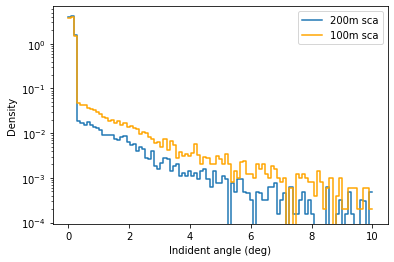

In [44]:
def make_plot_data(data):

    arriv_dirs = data[1]
    theta = np.arccos(arriv_dirs[:, 2])
    prop_dist = data[0] * c_medium_f(led_wavelength)/1E9 
    abs_weight = np.exp(-prop_dist / abs_len)

    return theta, abs_weight


pl_data_1 = make_plot_data(data)
pl_data_2 = make_plot_data(data2)

sns.histplot(x=np.degrees(pl_data_1[0]), bins=np.linspace(0, 10, 100), weights=pl_data_1[1], stat="density", label="200m sca", fill=False, element="step")
sns.histplot(x=np.degrees(pl_data_2[0]), bins=np.linspace(0, 10, 100), weights=pl_data_2[1], color="orange", stat="density", label="100m sca", fill=False, element="step")



plt.semilogy()
plt.xlabel("Indident angle (deg)")
plt.legend()
